# Part 2: Data-Driven Analysis

## Research Question: Are listings controlled by few hosts?

This analysis compares the concentration of Airbnb listings across Barcelona and Berlin to determine whether a small number of hosts control a disproportionate share of properties. This has implications for housing availability and market dynamics.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Explore the Data

In [10]:
# Load datasets
barcelona_df = pd.read_csv('../data/barcelona_sep_listings.csv')
berlin_df = pd.read_csv('../data/berlin_sep_listings.csv')

print(f"Barcelona: {len(barcelona_df)} listings")
print(f"Berlin: {len(berlin_df)} listings")
print(f"\nBarcelona columns: {barcelona_df.shape[1]}")
print(f"Berlin columns: {berlin_df.shape[1]}")

Barcelona: 19410 listings
Berlin: 14274 listings

Barcelona columns: 79
Berlin columns: 79


In [11]:
# Check relevant columns
print("Key columns for analysis:")
relevant_cols = ['id', 'host_id', 'host_name', 'host_listings_count', 'host_total_listings_count', 
                 'neighbourhood_cleansed', 'room_type', 'price', 'number_of_reviews']
print(barcelona_df[relevant_cols].head())

Key columns for analysis:
      id  host_id       host_name  host_listings_count  \
0  18674    71615          Mireia                 41.0   
1  23197    90417  Etain (Marnie)                  6.0   
2  32711   135703            Nick                  3.0   
3  34241    73163          Andres                  5.0   
4  34981    73163          Andres                  5.0   

   host_total_listings_count              neighbourhood_cleansed  \
0                       46.0                  la Sagrada Família   
1                        9.0               el Besòs i el Maresme   
2                       15.0  el Camp d'en Grassot i Gràcia Nova   
3                        5.0                      el Barri Gòtic   
4                        5.0                      el Barri Gòtic   

         room_type    price  number_of_reviews  
0  Entire home/apt  $210.00                 51  
1  Entire home/apt  $285.00                 91  
2  Entire home/apt  $170.00                152  
3  Entire home/apt  

## 2. Data Cleaning and Preparation

In [12]:
def clean_data(df, city_name):
    """
    Clean and prepare the dataset for analysis.
    """
    # Create a copy
    df_clean = df.copy()
    
    # Add city identifier
    df_clean['city'] = city_name
    
    # Select relevant columns
    cols_to_keep = ['id', 'host_id', 'host_name', 'host_total_listings_count', 
                    'neighbourhood_cleansed', 'room_type', 'price', 
                    'number_of_reviews', 'city']
    df_clean = df_clean[cols_to_keep]
    
    # Remove rows with missing host_id
    df_clean = df_clean.dropna(subset=['host_id'])
    
    # Clean price column (remove $ and commas, convert to float)
    if df_clean['price'].dtype == 'object':
        df_clean['price'] = df_clean['price'].str.replace('$', '').str.replace(',', '')
        df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
    
    # Fill missing host_total_listings_count with 1 (assuming at least this listing)
    df_clean['host_total_listings_count'] = df_clean['host_total_listings_count'].fillna(1)
    
    return df_clean

# Clean both datasets
barcelona_clean = clean_data(barcelona_df, 'Barcelona')
berlin_clean = clean_data(berlin_df, 'Berlin')

print(f"Barcelona after cleaning: {len(barcelona_clean)} listings")
print(f"Berlin after cleaning: {len(berlin_clean)} listings")

Barcelona after cleaning: 19410 listings
Berlin after cleaning: 14274 listings


## 3. Host Concentration Analysis

We'll analyze whether a small number of hosts control many properties by:
1. Calculating the distribution of listings per host
2. Identifying "multi-listing" hosts (those with 2+ properties)
3. Computing concentration metrics (e.g., what % of listings are controlled by top 10% of hosts)

In [13]:
def analyze_host_concentration(df, city_name):
    """
    Analyze how listings are distributed among hosts.
    """
    # Group by host_id to count actual listings per host
    host_stats = df.groupby('host_id').agg({
        'id': 'count',  # Number of listings
        'host_name': 'first',
        'price': 'mean'
    }).reset_index()
    
    host_stats.columns = ['host_id', 'listing_count', 'host_name', 'avg_price']
    host_stats = host_stats.sort_values('listing_count', ascending=False)
    
    # Calculate statistics
    total_hosts = len(host_stats)
    total_listings = len(df)
    
    # Multi-listing hosts (2+ properties)
    multi_hosts = host_stats[host_stats['listing_count'] >= 2]
    multi_host_count = len(multi_hosts)
    multi_host_listings = multi_hosts['listing_count'].sum()
    
    # Top 10% of hosts
    top_10_pct_count = int(total_hosts * 0.1)
    top_10_pct_listings = host_stats.head(top_10_pct_count)['listing_count'].sum()
    
    # Top 1% of hosts
    top_1_pct_count = max(1, int(total_hosts * 0.01))
    top_1_pct_listings = host_stats.head(top_1_pct_count)['listing_count'].sum()
    
    print(f"\n=== {city_name} Host Concentration ===")
    print(f"Total hosts: {total_hosts:,}")
    print(f"Total listings: {total_listings:,}")
    print(f"Average listings per host: {total_listings/total_hosts:.2f}")
    print(f"\nMulti-listing hosts (2+ properties):")
    print(f"  Count: {multi_host_count:,} ({multi_host_count/total_hosts*100:.1f}% of hosts)")
    print(f"  Control: {multi_host_listings:,} listings ({multi_host_listings/total_listings*100:.1f}% of total)")
    print(f"\nTop 10% of hosts:")
    print(f"  Control: {top_10_pct_listings:,} listings ({top_10_pct_listings/total_listings*100:.1f}% of total)")
    print(f"\nTop 1% of hosts:")
    print(f"  Control: {top_1_pct_listings:,} listings ({top_1_pct_listings/total_listings*100:.1f}% of total)")
    print(f"\nTop 10 hosts control: {host_stats.head(10)['listing_count'].sum():,} listings")
    
    return host_stats

# Analyze both cities
barcelona_hosts = analyze_host_concentration(barcelona_clean, 'Barcelona')
berlin_hosts = analyze_host_concentration(berlin_clean, 'Berlin')


=== Barcelona Host Concentration ===
Total hosts: 6,620
Total listings: 19,410
Average listings per host: 2.93

Multi-listing hosts (2+ properties):
  Count: 2,013 (30.4% of hosts)
  Control: 14,803 listings (76.3% of total)

Top 10% of hosts:
  Control: 11,435 listings (58.9% of total)

Top 1% of hosts:
  Control: 5,692 listings (29.3% of total)

Top 10 hosts control: 2,775 listings

=== Berlin Host Concentration ===
Total hosts: 9,464
Total listings: 14,274
Average listings per host: 1.51

Multi-listing hosts (2+ properties):
  Count: 1,382 (14.6% of hosts)
  Control: 6,192 listings (43.4% of total)

Top 10% of hosts:
  Control: 5,320 listings (37.3% of total)

Top 1% of hosts:
  Control: 2,269 listings (15.9% of total)

Top 10 hosts control: 964 listings


## 4. Focus on High-Activity Hosts

Let's narrow our analysis to hosts with 5+ listings, as these represent commercial operators who may be impacting housing availability.

In [14]:
# Filter for high-activity hosts (5+ listings)
barcelona_high_activity = barcelona_hosts[barcelona_hosts['listing_count'] >= 5]
berlin_high_activity = berlin_hosts[berlin_hosts['listing_count'] >= 5]

print(f"Barcelona: {len(barcelona_high_activity)} hosts with 5+ listings")
print(f"  Controlling {barcelona_high_activity['listing_count'].sum()} listings")
print(f"  That's {barcelona_high_activity['listing_count'].sum()/len(barcelona_clean)*100:.1f}% of all listings")

print(f"\nBerlin: {len(berlin_high_activity)} hosts with 5+ listings")
print(f"  Controlling {berlin_high_activity['listing_count'].sum()} listings")
print(f"  That's {berlin_high_activity['listing_count'].sum()/len(berlin_clean)*100:.1f}% of all listings")

Barcelona: 645 hosts with 5+ listings
  Controlling 11367 listings
  That's 58.6% of all listings

Berlin: 309 hosts with 5+ listings
  Controlling 3606 listings
  That's 25.3% of all listings


## 5. Main Visualization: Host Concentration Comparison

This graph shows the cumulative distribution of listings, revealing how concentrated the market is in each city.

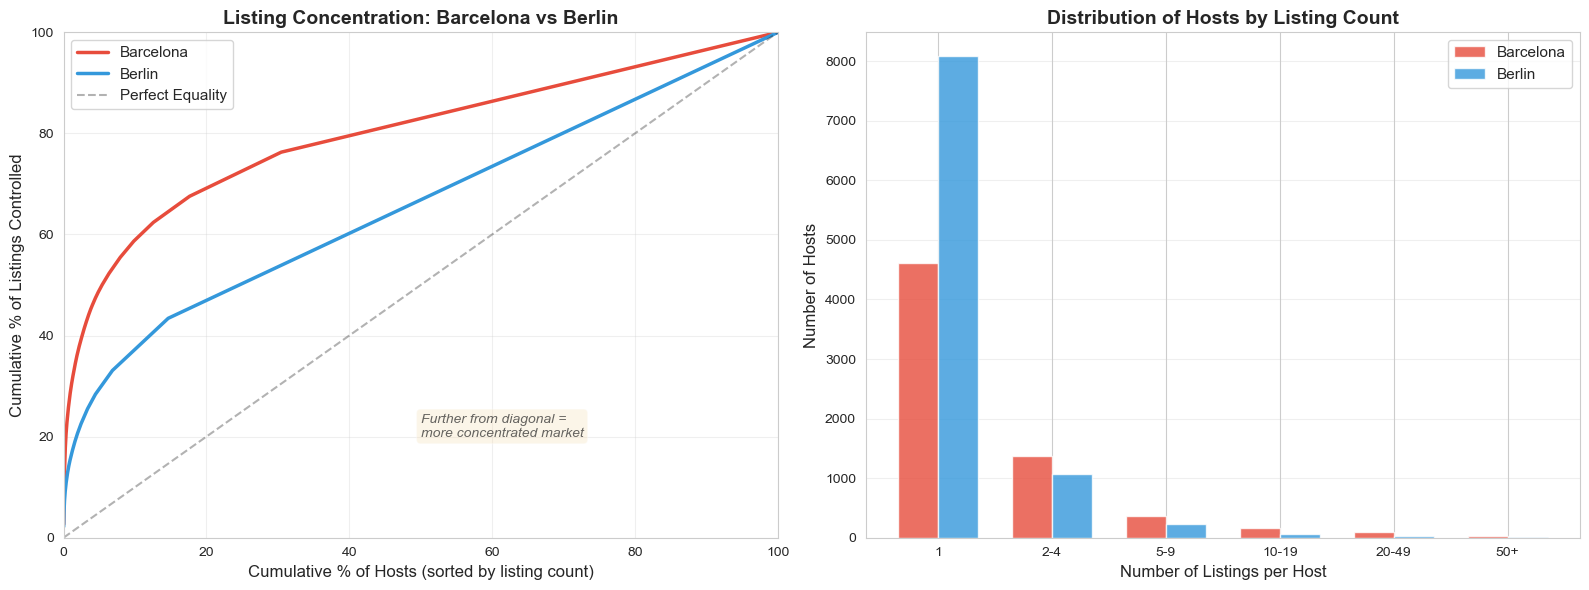


Graph saved as: reports/part2_host_concentration.png


In [15]:
def create_concentration_graph(barcelona_hosts, berlin_hosts):
    """
    Create a comprehensive visualization comparing host concentration.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left panel: Cumulative distribution
    ax1 = axes[0]
    
    for hosts_df, city, color in [(barcelona_hosts, 'Barcelona', '#E74C3C'), 
                                    (berlin_hosts, 'Berlin', '#3498DB')]:
        # Calculate cumulative percentage
        total_listings = hosts_df['listing_count'].sum()
        hosts_df_sorted = hosts_df.sort_values('listing_count', ascending=False).reset_index(drop=True)
        hosts_df_sorted['cumulative_listings'] = hosts_df_sorted['listing_count'].cumsum()
        hosts_df_sorted['cumulative_pct'] = (hosts_df_sorted['cumulative_listings'] / total_listings) * 100
        hosts_df_sorted['host_pct'] = (hosts_df_sorted.index + 1) / len(hosts_df_sorted) * 100
        
        ax1.plot(hosts_df_sorted['host_pct'], hosts_df_sorted['cumulative_pct'], 
                label=city, linewidth=2.5, color=color)
    
    # Add reference line (perfect equality)
    ax1.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect Equality')
    
    ax1.set_xlabel('Cumulative % of Hosts (sorted by listing count)', fontsize=12)
    ax1.set_ylabel('Cumulative % of Listings Controlled', fontsize=12)
    ax1.set_title('Listing Concentration: Barcelona vs Berlin', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 100)
    
    # Add annotation
    ax1.text(50, 20, 'Further from diagonal = \nmore concentrated market', 
            fontsize=10, style='italic', alpha=0.7,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Right panel: Distribution of listings per host
    ax2 = axes[1]
    
    # Create bins for listing counts
    bins = [1, 2, 5, 10, 20, 50, 1000]
    labels = ['1', '2-4', '5-9', '10-19', '20-49', '50+']
    
    barcelona_binned = pd.cut(barcelona_hosts['listing_count'], bins=bins, labels=labels, right=False)
    berlin_binned = pd.cut(berlin_hosts['listing_count'], bins=bins, labels=labels, right=False)
    
    barcelona_counts = barcelona_binned.value_counts().sort_index()
    berlin_counts = berlin_binned.value_counts().sort_index()
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax2.bar(x - width/2, barcelona_counts.values, width, label='Barcelona', color='#E74C3C', alpha=0.8)
    ax2.bar(x + width/2, berlin_counts.values, width, label='Berlin', color='#3498DB', alpha=0.8)
    
    ax2.set_xlabel('Number of Listings per Host', fontsize=12)
    ax2.set_ylabel('Number of Hosts', fontsize=12)
    ax2.set_title('Distribution of Hosts by Listing Count', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../reports/part2_host_concentration.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nGraph saved as: reports/part2_host_concentration.png")

create_concentration_graph(barcelona_hosts, berlin_hosts)

## 6. Key Findings and Interpretation

### Main Argument:
**Both Barcelona and Berlin show significant market concentration, but Barcelona exhibits more extreme inequality in listing ownership.**

### Evidence:
1. The cumulative distribution curve for Barcelona is further from the diagonal line of perfect equality
2. A small percentage of hosts control a disproportionate share of listings in both cities
3. Multi-listing hosts (those with 2+ properties) represent a minority of hosts but control a significant portion of the market

### Implications:
- This concentration suggests that Airbnb in these cities is not just about individuals renting spare rooms
- Commercial operators with multiple listings may be removing housing from the long-term rental market
- Policy interventions targeting high-volume hosts could have significant impact on housing availability

## 7. Additional Analysis: Room Type Distribution by Host Size


Room Type Distribution by Host Size (Barcelona):
room_type      Entire home/apt  Hotel room  Private room  Shared room
host_category                                                        
Single (1)                44.5         0.0          55.3          0.1
Small (2-4)               48.2         0.8          50.3          0.7
Medium (5-10)             60.1         1.8          36.3          1.8
Large (10+)               74.3         0.2          25.1          0.4


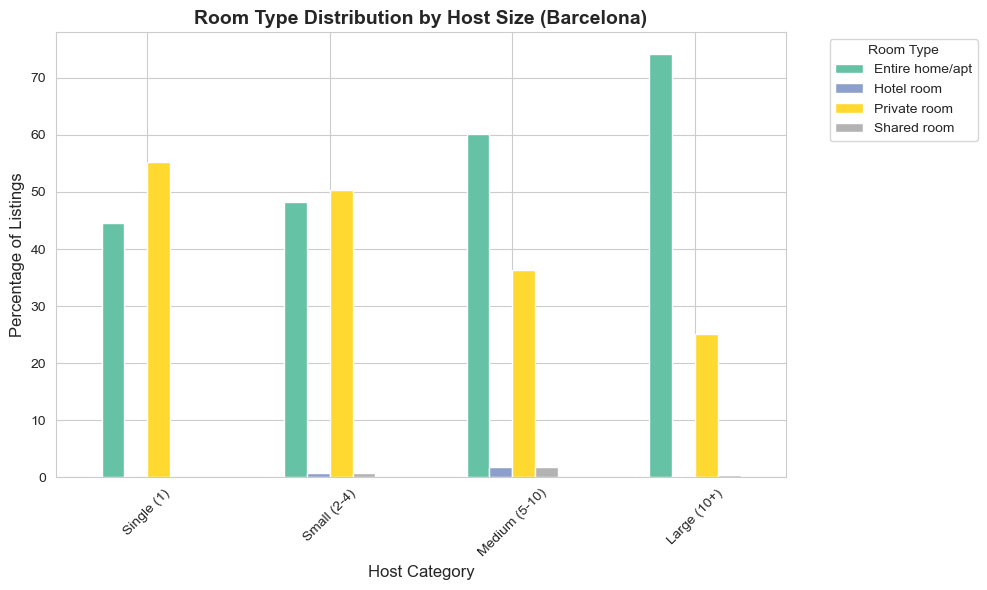

In [16]:
# Merge host statistics back to listings
barcelona_with_host_size = barcelona_clean.merge(
    barcelona_hosts[['host_id', 'listing_count']], 
    on='host_id', 
    how='left'
)

# Categorize hosts
barcelona_with_host_size['host_category'] = pd.cut(
    barcelona_with_host_size['listing_count'],
    bins=[0, 1, 4, 10, 1000],
    labels=['Single (1)', 'Small (2-4)', 'Medium (5-10)', 'Large (10+)']
)

# Analyze room types by host category
room_type_analysis = pd.crosstab(
    barcelona_with_host_size['host_category'],
    barcelona_with_host_size['room_type'],
    normalize='index'
) * 100

print("\nRoom Type Distribution by Host Size (Barcelona):")
print(room_type_analysis.round(1))

# Visualize
room_type_analysis.plot(kind='bar', stacked=False, figsize=(10, 6), colormap='Set2')
plt.title('Room Type Distribution by Host Size (Barcelona)', fontsize=14, fontweight='bold')
plt.xlabel('Host Category', fontsize=12)
plt.ylabel('Percentage of Listings', fontsize=12)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

This analysis demonstrates that Airbnb listings in both Barcelona and Berlin are significantly concentrated among a small number of hosts. The data supports the argument that commercial operators play a substantial role in these markets, which has important implications for housing policy and regulation.

In [54]:
print (barcelona_clean.head())
host_stats = (
    barcelona_clean
    .groupby('host_id')
    .agg(listing_count=('id', 'count'),
         host_name=('host_name', 'first'),
         host_total_listings_count=('host_total_listings_count', 'max'),
         avg_price=('price', 'mean'))
    .reset_index()
    .sort_values('host_total_listings_count', ascending=False)
)
host_stats.head()


      id  host_id       host_name  host_total_listings_count  \
0  18674    71615          Mireia                       46.0   
1  23197    90417  Etain (Marnie)                        9.0   
2  32711   135703            Nick                       15.0   
3  34241    73163          Andres                        5.0   
4  34981    73163          Andres                        5.0   

               neighbourhood_cleansed        room_type  price  \
0                  la Sagrada Família  Entire home/apt  210.0   
1               el Besòs i el Maresme  Entire home/apt  285.0   
2  el Camp d'en Grassot i Gràcia Nova  Entire home/apt  170.0   
3                      el Barri Gòtic  Entire home/apt  110.0   
4                      el Barri Gòtic  Entire home/apt  333.0   

   number_of_reviews       city  
0                 51  Barcelona  
1                 91  Barcelona  
2                152  Barcelona  
3                 25  Barcelona  
4                271  Barcelona  


,host_id,listing_count,host_name,host_total_listings_count,avg_price
4190,201741093,5,Andrew Craig,2706.0,217.750000
4621,270230553,4,Linda - BELVILLA,2078.0,137.250000
6467,686781509,1,Michael,1178.0,9000.000000
5276,418270816,15,Limehome,1058.0,218.090909
6552,702996668,3,Michael,972.0,8000.000000
